In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

In [2]:
import torch
import pandas as pd
from src.tools.preprocess import preprocess_data
import matplotlib.pyplot as plt
import rasterio
from skimage import exposure
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import joblib

from sklearn.metrics import classification_report

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [62]:
data = pd.read_csv('../data/processed/data.csv')
data_clean, anomalie = preprocess_data(data)
data_clean.head()

,Unnamed: 0,FarmID,category,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,...,ndwi,gndvi,savi,msavi,SDate_year,SDate_month,SDate_day,HDate_year,HDate_month,HDate_day
0,0.0,1326576.0,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-11-25,2024-04-14,97.0,...,8.488031,0.127153,0.151125,4232.596191,2023,11,25,2024,4,14
1,1.0,1326577.0,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-11-13,2024-04-26,82.0,...,11.493762,0.187815,0.282110,3249.392822,2023,11,13,2024,4,26
2,2.0,1326578.0,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-12-19,2024-04-28,92.0,...,10.166884,0.206553,0.309869,3741.956055,2023,12,19,2024,4,28
3,3.0,1331836.0,Diseased,Paddy,Telangana,Medak,Kulcharam,2023-02-11,2024-11-04,91.0,...,10.446196,0.220995,0.309350,3673.396729,2023,2,11,2024,11,4
4,4.0,1326579.0,Diseased,Paddy,Telangana,Medak,Kulcharam,2023-12-12,2024-05-19,94.0,...,8.665929,0.160657,0.269563,4227.338379,2023,12,12,2024,5,19


In [63]:
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
from PIL import Image


def scale_band(band):
    """Scale band data to 0-255."""
    band_min = np.min(band)
    band_max = np.max(band)
    return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


class TiffDataset(Dataset):
    def __init__(self, directory, data, type="train", transform=None, gamma=0.6, contrast_stretch=True):
        self.directory = directory
        self.transform = transform
        self.gamma = gamma
        self.contrast_stretch = contrast_stretch
        self.images = data.loc[(data["tif_path"].str.endswith('.tif')) & (data["dataset"] == type),
                               "tif_path"
                               ].tolist()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.images[idx])

        # Open the image file
        with rasterio.open(img_path) as src:
            # Read RGB bands (assuming Sentinel-2 band order: Red=B4, Green=B3, Blue=B2)
            red = src.read(3)
            green = src.read(2)
            blue = src.read(1)
            # Stack the scaled RGB bands into a single image
            rgb = np.dstack((red, green,
                            blue)).astype(np.uint8)

            # Convert NumPy array to PIL Image
            rgb = Image.fromarray(rgb)

            if self.transform:
                rgb = self.transform(rgb)

        return rgb

In [64]:
transform = transforms.Compose([
    transforms.Resize((16, 16)),
    transforms.RandomRotation(degrees=30),
    transforms.RandomAffine(translate=(0.1, 0.1), degrees=20),
    transforms.ToTensor()
])


train_dataset = TiffDataset(
    directory="../data", data=data_clean, type="train", transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TiffDataset(
    directory="../data", data=data_clean, type="test", transform=transform)
test_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAE, self).__init__()
        
        # Encodeur
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # 8x8
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 4x4
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 2x2
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Flatten()
        )
        
        # Couches pour la moyenne et la variance
        self.fc_mu = nn.Linear(128 * 2 * 2, latent_dim)
        self.fc_var = nn.Linear(128 * 2 * 2, latent_dim)
        
        # Décodeur
        self.decoder_input = nn.Linear(latent_dim, 128 * 2 * 2)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 4x4
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8x8
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x16
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def reparametrize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.decoder_input(z)
        z = z.view(-1, 128, 2, 2)
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparametrize(mu, log_var)
        return self.decode(z), mu, log_var

def loss_function(recon_x, x, mu, log_var):
    # Perte de reconstruction (MSE)
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    
    # Divergence KL
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return MSE + KLD

# Exemple d'utilisation
def train_vae(vae, train_loader, optimizer, epochs=100):
    vae.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, data in enumerate(train_loader):
            optimizer.zero_grad()
            data = data.to(device)
            recon_batch, mu, log_var = vae(data)
            loss = loss_function(recon_batch, data, mu, log_var)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        avg_loss = total_loss / len(train_loader.dataset)
        print(f'Epoch [{epoch+1}/{epochs}] Average Loss: {avg_loss:.4f}')

In [14]:
varencoder = VAE().to(device)

In [67]:
train_vae(varencoder, train_dataloader, torch.optim.Adam(varencoder.parameters(), lr=0.0001), epochs=20)

Epoch [1/20] Average Loss: 30.4353
Epoch [2/20] Average Loss: 30.4238
Epoch [3/20] Average Loss: 30.4172
Epoch [4/20] Average Loss: 30.3235
Epoch [5/20] Average Loss: 30.4420
Epoch [6/20] Average Loss: 30.3506
Epoch [7/20] Average Loss: 30.4210
Epoch [8/20] Average Loss: 30.3080
Epoch [9/20] Average Loss: 30.3842
Epoch [10/20] Average Loss: 30.3134
Epoch [11/20] Average Loss: 30.3657
Epoch [12/20] Average Loss: 30.4004
Epoch [13/20] Average Loss: 30.3371
Epoch [14/20] Average Loss: 30.3011
Epoch [15/20] Average Loss: 30.4047
Epoch [16/20] Average Loss: 30.3734
Epoch [17/20] Average Loss: 30.3540
Epoch [18/20] Average Loss: 30.4125
Epoch [19/20] Average Loss: 30.3920
Epoch [20/20] Average Loss: 30.3988


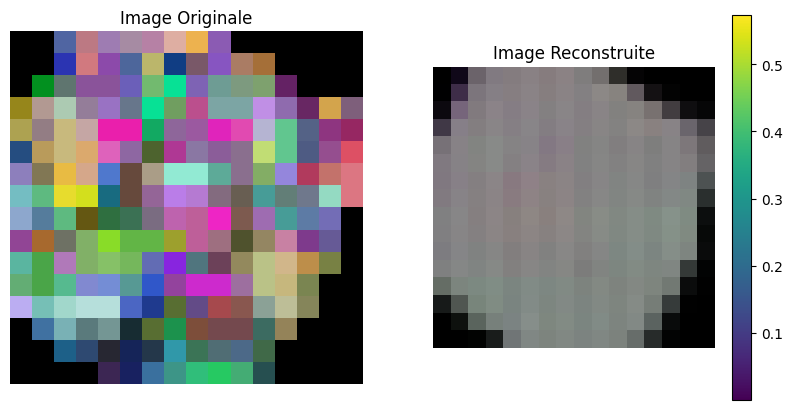

In [68]:
for batch_idx, data in enumerate(test_dataloader):
    with torch.no_grad():
     
        data = data.to(device)[0]
      
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

       
        axs[0].imshow(data.cpu().numpy().transpose(1, 2, 0))
        axs[0].set_title('Image Originale')
        axs[0].axis('off')  # Masquer les axes

    
        output, mu, log_var = varencoder(data.unsqueeze(0))
        
        output = output.view(3, 16, 16)


        axs[1].imshow(output.cpu().numpy().transpose(1, 2, 0))
        axs[1].set_title('Image Reconstruite')
        axs[1].axis('off')  

        plt.colorbar(axs[1].imshow(output.cpu().numpy().transpose(
            1, 2, 0)), ax=axs[1]) 
        plt.show()

        break

In [70]:
X = []
y = []
for index, row in data_clean.iterrows():
    try:
        img_path = os.path.join("../data", row["tif_path"])
        x = []
        y.append(row['category'])
        with rasterio.open(img_path) as src:
            red = src.read(3)
            green = src.read(2)
            blue = src.read(1)

            rgb = np.dstack((red, green,
                            blue)).astype(np.uint8)
            rgb = Image.fromarray(rgb)
            rgb = transform(rgb).unsqueeze(0).to(device)
            output, mu = varencoder.encode(rgb)
            output = output.cpu().detach().numpy().squeeze()
            output = [float(x) for x in output]
            x.extend(output)
            X.append(x)
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

Error processing ../data/downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-06-11_2024-02-21.tif: join() argument must be str, bytes, or os.PathLike object, not 'float'
Error processing ../data/downloads/20240422T050649_20240422T051633_T44QLE_RGB_2024-04-21_2024-04-23.tif: join() argument must be str, bytes, or os.PathLike object, not 'float'
Error processing ../data/downloads/20231025T050859_20231025T051705_T43QHA_RGB_2023-09-07_2023-10-26.tif: join() argument must be str, bytes, or os.PathLike object, not 'float'
Error processing ../data/downloads/20240815T050651_20240815T051557_T44QLE_RGB_2023-06-22_2024-08-17.tif: join() argument must be str, bytes, or os.PathLike object, not 'float'
Error processing ../data/downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-10-26_2024-04-14.tif: join() argument must be str, bytes, or os.PathLike object, not 'float'
Error processing ../data/downloads/20231015T050759_20231015T051410_T44QME_RGB_2023-01-06_2023-10-17.tif: join() argument

In [94]:
def encode_data(data):
    X = []
    for index, row in data.iterrows():
        try:
            img_path = os.path.join("../data", row["tif_path"])
            x = []
            with rasterio.open(img_path) as src:
                red = src.read(3)
                green = src.read(2)
                blue = src.read(1)

                rgb = np.dstack((red, green,
                                blue)).astype(np.uint8)
                rgb = Image.fromarray(rgb)
                rgb = transform(rgb).unsqueeze(0).to(device)
                output, mu = varencoder.encode(rgb)
                output = output.cpu().detach().numpy().squeeze()
                output = [float(x) for x in output]
                x.extend(output)
                X.append(x)
        except Exception as e:
            print(row)
            print(f"Error processing {img_path}: {e}")
    return X

In [82]:
print(np.unique(y))
X, y = np.array(X), np.array(y)
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

[0 1 2 3]


In [83]:
X_train.shape,y_train.shape

((8476, 32), (8476,))

In [84]:
load_model = False
if load_model:
    best_lenear_model = joblib.load('best_svm_model.joblib')
else:
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto', 0.1, 0.01]
    }
    svm = SVC(random_state=42)
    grid_search = GridSearchCV(
        svm, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train, y_train)
    best_lenear_model = grid_search.best_estimator_
    cv_scores = cross_val_score(
        best_lenear_model, X_train, y_train, cv=5, scoring='f1_macro'
    )
    
    cv_scores

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [85]:
y_pred = best_lenear_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.07      0.04      0.05        91
           1       0.89      0.95      0.91      1873
           2       0.04      0.01      0.02        75
           3       0.00      0.00      0.00        80

    accuracy                           0.84      2119
   macro avg       0.25      0.25      0.25      2119
weighted avg       0.79      0.84      0.81      2119



In [96]:
test_encoded = pd.read_csv("../data/processed/data.csv")

test_encoded = test_encoded[test_encoded["dataset"]=="test"]
test_encoded['FarmID'] = test_encoded["FarmID"].astype(str)
test_encoded.drop(columns=["category"], inplace=True)
test_encoded, anomalies = preprocess_data(test_encoded)

X_test_submission =encode_data(test_encoded)
X_test_submission = scaler.transform(X_test_submission)




test_predictions = best_lenear_model.predict(X_test_submission)
test_predictions_decoded = le.inverse_transform(test_predictions)

sample_submission = pd.DataFrame()
sample_submission['ID'] = test_encoded["FarmID"].astype(str)  # Convertir en chaîne de caractères
sample_submission['Target'] = test_predictions_decoded

# Aperçu du DataFrame
sample_submission.head()

# Sauvegarder le fichier de soumission
sample_submission.to_csv('submission_4.csv', index=False)

Unnamed: 0                                                    8328.0
FarmID                                                       1328745
Crop                                                          Cotton
State                                                      Telangana
District                                                    Nalgonda
Sub-District                                                Munugode
SDate                                            2023-12-30 00:00:00
HDate                                            2024-01-03 00:00:00
CropCoveredArea                                                 81.0
CHeight                                                        114.0
CNext                                                        Sorghum
CLast                                                          Maize
CTransp                                                     Drilling
IrriType                                                   Sprinkler
IrriSource                        

ValueError: Length of values (2715) does not match length of index (2718)